# Compare QTLs with and without cell populations
- V03: Add analysis of interaction terms
- V02: compare top hit (the same variant in both analyses)


In [1]:
setwd("/frazer01/projects/GTEx_v7/analysis/eqtls_deconvolution")

In [2]:
invisible(suppressWarnings(file.link("/frazer01/home//matteo/notebooks/eqtls_deconvolution_gtex//analyze_qtl_results.ipynb", "analysis/analyze_qtl_results.ipynb")))

source("analysis/cardiac_qtls_packages.R"      )
source("analysis/cardiac_qtls_input_files.R"   )
source("analysis/cardiac_qtls_functions.R"     )
source("analysis/cardiac_qtls_input_data.R"    )
source("analysis/cardiac_qtls_load_metadata.R" )


Loading packages...
Warning message:
“replacing previous import ‘BiocGenerics::dims’ by ‘Biobase::dims’ when loading ‘AnnotationDbi’”Warning message:
“replacing previous import ‘BiocGenerics::dims’ by ‘Biobase::dims’ when loading ‘DESeq’”Loading input files...
Loading functions...
Loading input data...
Loading metadata...


In [3]:
nrow(read.table(paste("qtls/", "liver_original", "/analysis/egenes.", "liver_original", ".txt", sep = ""), header = TRUE))
nrow(read.table(paste("qtls/", "skin_original" , "/analysis/egenes.", "skin_original" , ".txt", sep = ""), header = TRUE))


[1] 19621

[1] 24029

In [4]:
tissues         = c("liver_original", "liver_cells", "liver2_cells", "skin_original", "skin_cells"  )
tissue2name     = data.frame(tissue = tissues, name = c("Liver (bulk resolution)", "Liver (mouse cell populations)", "Liver (human cell populations)", "Skin (original)", "Skin (mouse cell populations)" ), color = c("#FF7256", "#CD3700", "#800000", "#87CEFA", "#000080"), y = c(5,3,4,2,1))
qtl_list        = lapply(tissues , function(x){read.table(paste("qtls/", x, "/analysis/egenes.", x, ".txt", sep = ""), header = TRUE)})
names(qtl_list) = tissues


In [7]:
lapply(qtl_list, function(x){nrow(x[x$egene == TRUE,])})

$liver_original
[1] 1369

$liver_cells
[1] 7840

$liver2_cells
[1] 10177

$skin_original
[1] 9232

$skin_cells
[1] 14174

In [9]:
14174/9232
9232/1369

[1] 1.535312

[1] 6.743608

In [59]:
qtl2egenes = function(qtl_list, tissue)
{
    x = qtl_list[[tissue]]
    return(data.frame(tissue = tissue, genes = nrow(x), egenes = nrow(x[x$egene == TRUE,])))
}

egenes = do.call("rbind", lapply(tissue2name$tissue, function(tissue){qtl2egenes(qtl_list, tissue)}))
egenes = merge(egenes, tissue2name)



In [60]:
qtl2overlap = function(qtl_list, tissue1, tissue2)
{
    x1 = qtl_list[[tissue1]]
    x2 = qtl_list[[tissue2]]
    
    x1$overlap = FALSE
    x1[x1$gene_id %in% x2[x2$egene == TRUE, "gene_id"], "overlap"] = TRUE
    
    return(x1)
}

qtl_list2 = list(liver_original = qtl2overlap(qtl_list, "liver_original", "liver_original"),
                 liver_cells    = qtl2overlap(qtl_list, "liver_cells"   , "liver_original"),
                 liver2_cells   = qtl2overlap(qtl_list, "liver2_cells"  , "liver_original"),
                 skin_original  = qtl2overlap(qtl_list, "skin_original" , "skin_original" ),
                 skin_cells     = qtl2overlap(qtl_list, "skin_cells"    , "skin_original" )
                )

# Compare with GTEx: 
- how many tissues eGene?

In [61]:
gtex_folder                    = "/publicdata/gtex_v7"
gtex2col                       = read.table(paste(gtex_folder, "Color_scheme", sep = "/"), header = FALSE, col.names = c("tissue", "color"), comment.char = "")
gtex_samples                   = read.table(paste(gtex_folder, "eqtl_summary.txt", sep = "/"), header = TRUE, sep = "\t")
gtex_samples$uberon            = NULL
gtex_samples$sample_size_total = NULL
gtex_samples$tissue            = gsub("EBV", "EBV-", gsub("c1", "c-1", gsub("[ ]+", "_", gsub("-", "", gsub("\\(", "", gsub("\\)", "", gtex_samples$tissue_name))))))
gtex_samples                   = merge(gtex_samples, gtex2col)
gtex_samples$egenes            = as.numeric(gtex_samples$egenes)


In [62]:
qtls_by_tissue = function(tissue)
{
    infile = paste("/publicdata/gtex_v7/GTEx_Analysis_v7_eQTL/", tissue, ".v7.egenes.txt", sep = "")
    indata = fread(infile, sep = "\t", header = TRUE, data.table = FALSE)
    
    return(data.frame(gene_id = indata[indata$qval < 0.05, "gene_id"], tissue = tissue))
}

qtls_all   = do.call("rbind", lapply(gtex_samples$tissue, qtls_by_tissue))
qtls_table = as.data.frame.matrix(table(qtls_all), stringsAsFactors = FALSE)
colnames(qtls_table) = tolower(colnames(qtls_table))

In [63]:
count_tissues = function(tissue, x, qtls_table)
{
    this         = qtls_table[,grepl(tissue, colnames(qtls_table)) == FALSE]
    tomerge      = data.frame(gene_id = rownames(this), n = rowSums(this))
    out          = merge(x, tomerge)
    out$abs_beta = abs(out$beta)
    out$diff     = out$se / out$abs_beta
    
    return(out)
}

qtls2n        = lapply(names(qtl_list2), function(tissue){count_tissues(tissue, qtl_list2[[tissue]], qtls_table)})
names(qtls2n) = names(qtl_list2)

tissue,cells,original
liver2_cells,14.68518,28.76384
liver_cells,15.12492,28.76384
skin_cells,11.31643,19.62152


tissue,cells,original
liver2_cells,1.6434867,1.988048
liver_cells,1.6676417,1.988048
skin_cells,0.9647676,1.065370


tissue,cells,original
liver2_cells,0.4419342,0.4967158
liver_cells,0.4472642,0.4967158
skin_cells,0.2311835,0.2487347


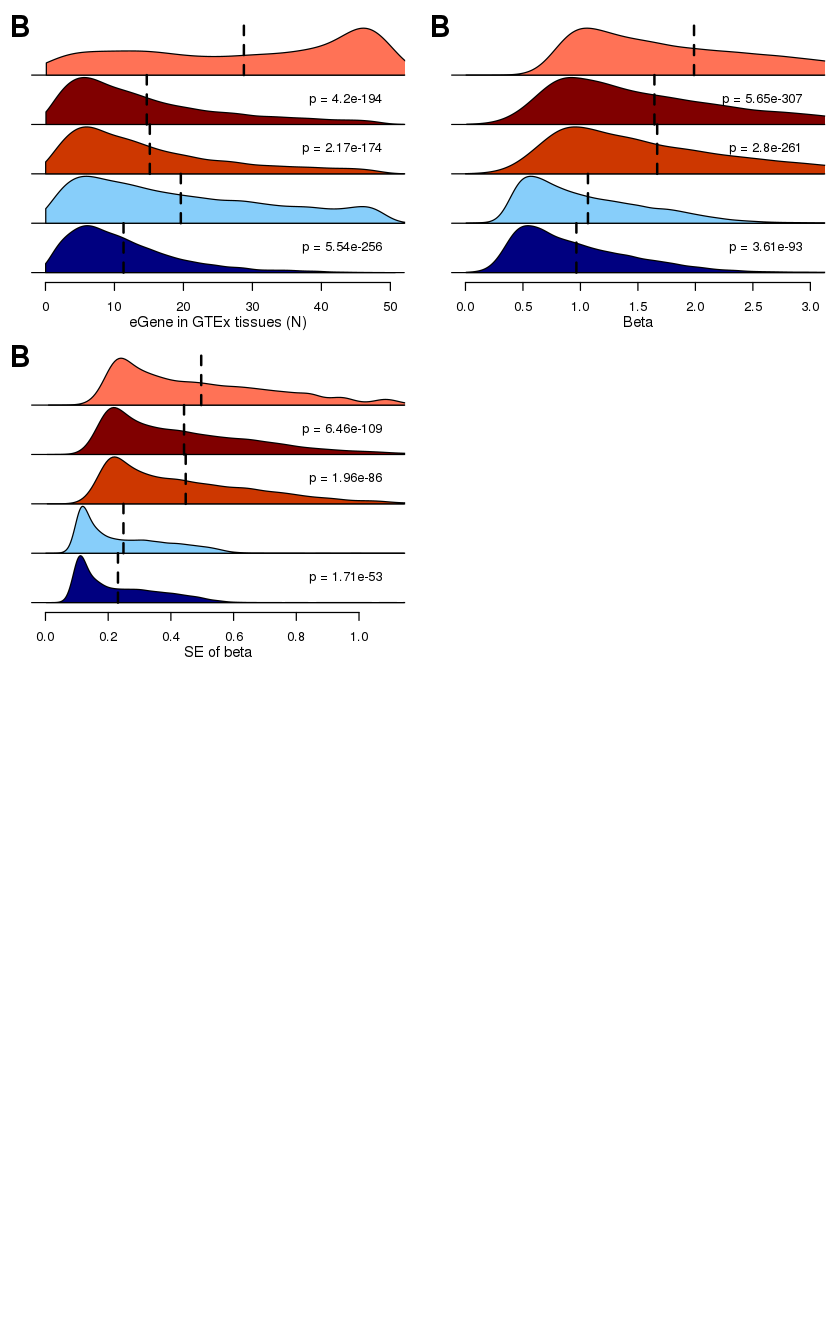

In [64]:
density_lines = function(x)
{
    if (length(x) > 0)
    {
        dens = density(x)
        dens = data.frame(x = dens$x, y = dens$y)
        dens = dens[dens$x >= 0,]
        
        dens = rbind(dens, data.frame(x = c(max(dens$x), min(dens$x)), y = c(0,0)))
        #dens = rbind(dens, data.frame(x = rev(xlim), y = c(0,0)))

        return(dens)
    }
}

polygon_density = function(dens, color, y0, yscale = 0.95)
{
    if (nrow(dens) > 0)
    {
        polygon(dens$x, (dens$y / max(dens$y) * yscale) + y0, col = color)
    }
}


plot_densities_gtex = function(qtls2n, column, filter, xmax, main, panel)
{
    if (filter == TRUE ){qtl2tissues_true  = lapply(qtls2n, function(x){x[x$egene == TRUE & x$overlap == TRUE , column]})}
    if (filter == TRUE ){qtl2tissues_false = lapply(qtls2n, function(x){x[x$egene == TRUE & x$overlap == FALSE, column]})}
    if (filter == FALSE){qtl2tissues_true  = lapply(qtls2n, function(x){x[, column]})}
    if (filter == FALSE){qtl2tissues_false = lapply(qtls2n, function(x){x[, column]})}
    names(qtl2tissues_true ) = names(qtl2tissues_true )
    names(qtl2tissues_false) = names(qtl2tissues_false)

    dens_list_true  = lapply(qtl2tissues_true , density_lines)
    dens_list_false = lapply(qtl2tissues_false, density_lines)

    tissue2name = tissue2name[order(tissue2name$y, decreasing = TRUE),]
    
    plot(1,1, type = "n", xlim = c(0, xmax), ylim = c(1,6), xlab = "", ylab = "", axes = FALSE)
    axis(1)
    mtext(text = main, side = 1, line = 2, cex = 0.75)
    abline(h = 1:5)

    polygon_density(dens_list_true [["liver_original"]], tissue2name[tissue2name$tissue == "liver_original", "color"], 6 - 1)
    polygon_density(dens_list_false[["liver2_cells"  ]], tissue2name[tissue2name$tissue == "liver2_cells"  , "color"], 6 - 2)
    polygon_density(dens_list_false[["liver_cells"   ]], tissue2name[tissue2name$tissue == "liver_cells"   , "color"], 6 - 3)
    polygon_density(dens_list_true [["skin_original" ]], tissue2name[tissue2name$tissue == "skin_original" , "color"], 6 - 4)
    polygon_density(dens_list_false[["skin_cells"    ]], tissue2name[tissue2name$tissue == "skin_cells"    , "color"], 6 - 5)
    
    segments(x0 = c(mean(qtl2tissues_true [["liver_original"]]), 
                    mean(qtl2tissues_false[["liver2_cells"  ]]), 
                    mean(qtl2tissues_false[["liver_cells"   ]]), 
                    mean(qtl2tissues_true [["skin_original" ]]), 
                    mean(qtl2tissues_false[["skin_cells"    ]])), 
             y0 = 6 - (1:5), y1 = 7 - (1:5), col = "#000000", lty = "dashed", lwd = 2)

    #text(x = rep(xmax/2, 5), y = (5:1)+0.5, labels = tissue2name$name, pos = 3)
    mtext(text = panel, side = 2, line = 0, cex = 1.5 , at = 6, las = 1, font = 2)

    text(xmax, 4.5, labels = paste("p", signif(wilcox.test(qtl2tissues_false[["liver2_cells"]], qtl2tissues_true[["liver_original"]])$p.value, digits = 3), sep = " = "), pos = 2)
    text(xmax, 3.5, labels = paste("p", signif(wilcox.test(qtl2tissues_false[["liver_cells" ]], qtl2tissues_true[["liver_original"]])$p.value, digits = 3), sep = " = "), pos = 2)
    text(xmax, 1.5, labels = paste("p", signif(wilcox.test(qtl2tissues_false[["skin_cells"  ]], qtl2tissues_true[["skin_original" ]])$p.value, digits = 3), sep = " = "), pos = 2)
    
    return(data.frame(tissue   = c("liver2_cells", "liver_cells", "skin_cells"), 
                      cells    = c(mean(qtl2tissues_false[["liver2_cells"  ]], na.rm = TRUE), mean(qtl2tissues_false[["liver_cells"   ]], na.rm = TRUE), mean(qtl2tissues_false[["skin_cells"   ]], na.rm = TRUE)),
                      original = c(mean(qtl2tissues_true [["liver_original"]], na.rm = TRUE), mean(qtl2tissues_true [["liver_original"]], na.rm = TRUE), mean(qtl2tissues_true [["skin_original"]], na.rm = TRUE))
                     ))
}

par(mfrow = c(4,2), mar = c(3,2,1,1))
plot_densities_gtex(qtls2n, "n"       , filter = TRUE , 50  , main = "eGene in GTEx tissues (N)", "B")
plot_densities_gtex(qtls2n, "abs_beta", filter = FALSE,  3  , main = "Beta"                     , "B")
plot_densities_gtex(qtls2n, "se"      , filter = FALSE,  1.1, main = "SE of beta"               , "B")



In [65]:
barplot_egenes = function(tissues, qtl_list, tissue2name)
{
    
    plot(1,1, type = "n", xlab = "", ylab = "", xlim = range(as.numeric(unlist(lapply(qtl_list, function(x){range(x$exp)})))), ylim = range(as.numeric(unlist(lapply(qtl_list, function(x){range(x$logp)})))))
    
    invisible(lapply(tissues, function(tissue){points(qtl_list[[tissue]][,"exp"], qtl_list[[tissue]][,"logp"], col = tissue2name[tissue2name$tissue == tissue, "color"], pch = 16)}))
}

#run_qqplot(tissues, qtl_list, tissue2name)


# Scatterplot QTLs

0.978320467875693
0.976226415021707
0.987722979923976
0.989260685409931


tissue,tissue1,tissue2,genes,ns,only1,only2,both
liver,liver_original,liver_cells,17983,10743,0,5973,1267
liver,liver_original,liver2_cells,17757,8443,0,8068,1246
liver,liver_cells,liver2_cells,17832,8075,364,2491,6902
skin,skin_original,skin_cells,23082,9452,0,4668,8962


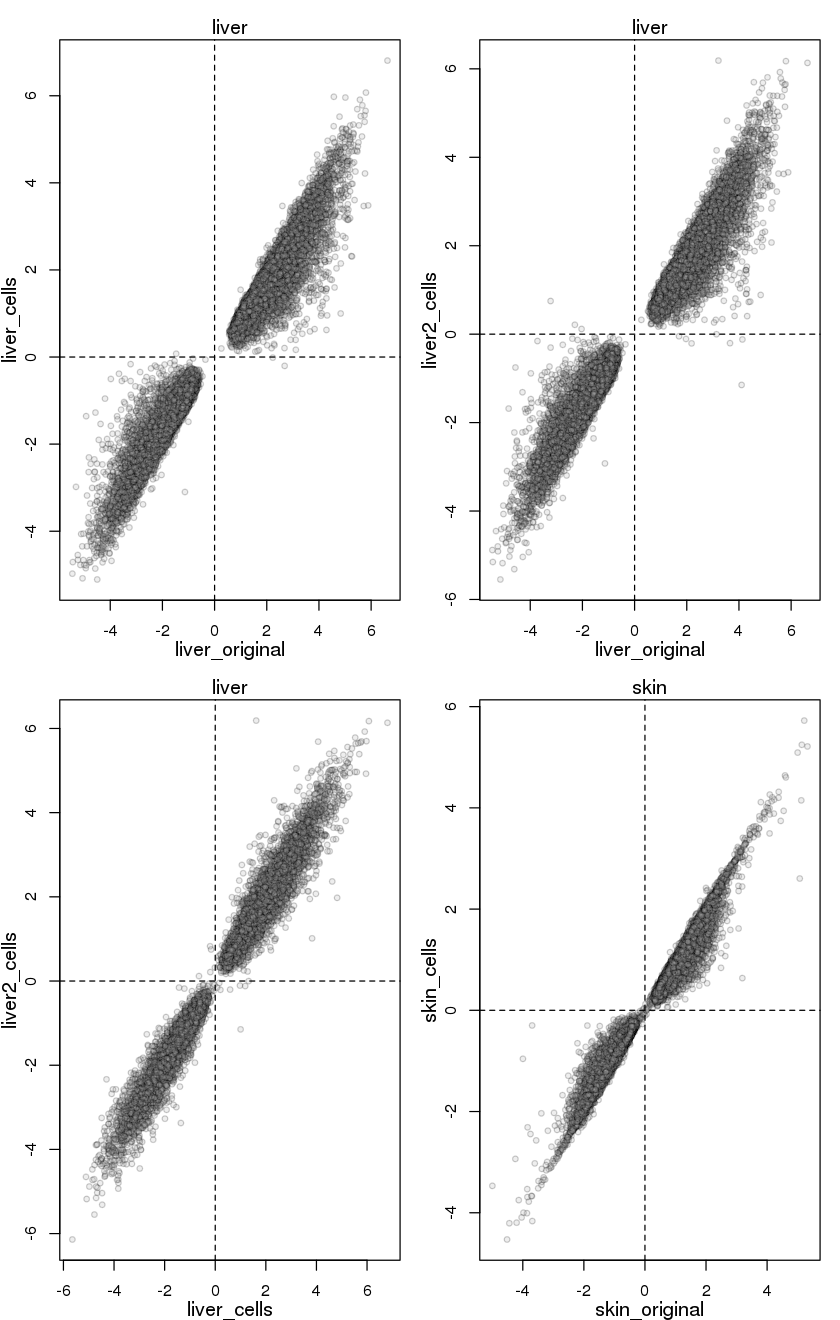

In [66]:
compare_qtls = function(tissue1, tissue2, tissue)
{
    qtls1 = read.table(paste("qtls/", tissue1, "/analysis/egenes.", tissue1, ".txt", sep = ""), header = TRUE)
    qtls2 = read.table(paste("qtls/", tissue2, "/analysis/egenes.", tissue2, ".txt", sep = ""), header = TRUE)
    qtls1$gene_var = paste(qtls1$gene_id, qtls1$id)
    qtls2$gene_var = paste(qtls2$gene_id, qtls2$id)
    
    qtls  = merge(qtls1[,c("gene_var", "egene", "beta", "se", "bonferroni")], qtls2[,c("gene_var", "egene", "beta", "se", "bonferroni")], by = "gene_var", suffixes = 1:2)
    
    qtls$color = "#aaaaaa"
    qtls[qtls$egene1 == TRUE  & qtls$egene2 == TRUE , "color"] = "#ff0000"
    qtls[qtls$egene1 == TRUE  & qtls$egene2 == FALSE, "color"] = "#ff00ff"
    qtls[qtls$egene1 == FALSE & qtls$egene2 == TRUE , "color"] = "#00ffff"
    qtls = rbind(qtls[qtls$egene1 == FALSE & qtls$egene2 == FALSE,],
                 qtls[qtls$egene1 == TRUE  & qtls$egene2 == TRUE ,],
                 qtls[qtls$egene1 == FALSE & qtls$egene2 == TRUE ,],
                 qtls[qtls$egene1 == TRUE  & qtls$egene2 == FALSE,]
                )
    
    message(cor(qtls$beta1, qtls$beta2))
    
    plot(qtls$beta1, qtls$beta2, bg = "#aaaaaa33", col = "#00000033", pch = 21, cex = 0.75, xlab = "", ylab = "", main = "")
    #smoothScatter(qtls$beta1, qtls$beta2, bg = qtls$color, xlab = "", ylab = "", main = "", nrpoints = 0)
    #points(qtls[qtls$egene1 == FALSE & qtls$egene2 == TRUE , "beta1"], qtls[qtls$egene1 == FALSE & qtls$egene2 == TRUE , "beta2"], bg = "#00ffff", pch = 21, cex = 0.75)
    #points(qtls[qtls$egene1 == TRUE  & qtls$egene2 == FALSE, "beta1"], qtls[qtls$egene1 == TRUE  & qtls$egene2 == FALSE, "beta2"], bg = "#ff00ff", pch = 21, cex = 0.75)
    
    abline(h = 0, lty = "dashed")
    abline(v = 0, lty = "dashed")
    mtext(text = tissue1, side = 1, line = 2  )
    mtext(text = tissue2, side = 2, line = 2  )
    mtext(text = tissue , side = 3, line = 0.1)
    
    #text(x = rep(min(qtls$beta1),5), y = (0:(-4)) + max(qtls$beta2), cex = 0.75, pos = 4,
    #     labels = c(paste("Genes", nrow(qtls1), sep = ": "),
    #                paste("Genes with the same top hit", nrow(qtls), sep = ": "),
    #                paste("eGenes", tissue1, "only:"   , nrow(qtls[qtls$egene1 == TRUE  & qtls$egene2 == FALSE,]), sep = " "),
    #                paste("eGenes", tissue2, "only:"   , nrow(qtls[qtls$egene1 == FALSE & qtls$egene2 == TRUE ,]), sep = " "),
    #                paste("eGenes both tissues:"       , nrow(qtls[qtls$egene1 == TRUE  & qtls$egene2 == TRUE ,]), sep = " ")))
    #
    #points(x = rep(min(qtls$beta1),3), y = (-2:(-4)) + max(qtls$beta2), pch = 21, bg = c("#ff00ff", "#00ffff", "#ff0000"))
    
    #legend("bottomright", pch = 21, pt.bg = c("#aaaaaa", "#ff00ff", "#00ffff", "#ff0000"),
    #       legend = c("Not significant", tissue1, tissue2, "Both"))
    
    write.table(qtls, file = paste("qtls", tissue1, tissue2, "txt", sep = "."), quote = FALSE, sep = "\t", row.names = FALSE, col.names = TRUE)
    
    return(data.frame(tissue  = tissue,
                      tissue1 = tissue1, 
                      tissue2 = tissue2, 
                      genes   = nrow(qtls), 
                      ns      = nrow(qtls[qtls$egene1 == FALSE & qtls$egene2 == FALSE,]),
                      only1   = nrow(qtls[qtls$egene1 == TRUE  & qtls$egene2 == FALSE,]),
                      only2   = nrow(qtls[qtls$egene1 == FALSE & qtls$egene2 == TRUE ,]),
                      both    = nrow(qtls[qtls$egene1 == TRUE  & qtls$egene2 == TRUE ,])
                     ))
    
    #return(list(#qtls1      = qtls1, 
    #            #qtls2      = qtls2,
    #            ttest_beta = t.test(abs(qtls$beta2), abs(qtls$beta1), paired = TRUE),
    #            ttest_se   = t.test(qtls$se2  , qtls$se1  , paired = TRUE)))
}

par(mfrow = c(2,2), mar = c(3,3,2,1))

out1 = compare_qtls("liver_original", "liver_cells" , "liver")
out2 = compare_qtls("liver_original", "liver2_cells", "liver")
out3 = compare_qtls("liver_cells"   , "liver2_cells", "liver")
out4 = compare_qtls("skin_original" , "skin_cells"  , "skin" )

qtl2plot = rbind(out1, out2, out3, out4)

qtl2plot

In [67]:
qtl2plot_data = function(tissue)
{
    qtls = read.table(paste("qtls/", tissue, "/analysis/egenes."     , tissue, ".txt", sep = ""), header = TRUE)
    
    out = data.frame(tissue = tissue, egenes = nrow(qtls[qtls$egene == TRUE,]), ns = nrow(qtls[qtls$egene == FALSE,]))
    
    return(out)
}

qtl2plot = do.call("rbind", lapply(c("liver_original", "liver_cells", "liver2_cells", "skin_original", "skin_cells"), qtl2plot_data))


# Add interaction terms

In [68]:
liver_cells  = c("endothelial", "hepatocyte", "kupffer_cell", "nk_cell")
liver2_cells = c("endothelial_venous", "gdt", "hepatocyte0", "hepatocyte3", "hepatocyte4", "macrophage", "nkt_cell", "endothelial_periportal")
skin_cells   = c("epidermal", "keratinocyte_stem_cell", "leucocyte", "epidermal_stem_cell")

liver2_cells = data.frame(celltypes = c('central_venous_sinusoidal_endothelial_cells', 'gdT_cell', 'Hepatocytes0', 'Hepatocytes3', 'Hepatocytes4', 'inflammatory_macrophages', 'NK.NKT_cell', 'Periportal_sinusoidal_endothelial_cells'),
                          name      = c("endothelial_venous"                         , "gdt"     , "hepatocyte0" , "hepatocyte3" , "hepatocyte4" , "macrophage"              , "nkt_cell"   , "endothelial_periportal"                 ),
                          color     = c("#00c2c0"                                    , "#fa9c00" , "#b53bc7"     ,  "#f1a8f2"    , "#ff4bcc"     , "#cdad02"                 , "#ff8e77"    , "#0075da"                                ))

liver_cells = data.frame(celltypes = c('endothelial_cell_of_hepatic_sinusoid', 'hepatocyte', 'Kupffer_cell', 'natural_killer_cell'),
                         name      = c("endothelial"                         , "hepatocyte", "kupffer_cell", "nk_cell"            ),
                         color     = c("#00c2c0"                             , "#b53bc7"   , "#f0d710"     , "#ff8e77"            ))

skin_cells = data.frame(celltypes = c("epidermal_cell", "keratinocyte_stem_cell", "leucocyte", "stem_cell_of_epidermis"),
                        name      = c("epidermal"     , "keratinocyte_stem_cell", "leucocyte", "epidermal_stem_cell"   ),
                        color     = c("#38ace2"       , "#a084bd"               , "#f067a1"  , "#e38725"               ))

cell2col = list(liver_cells = liver_cells, liver2_cells = liver2_cells, skin_cells = skin_cells)


In [69]:
cell2col[[x]]

celltypes,name,color
endothelial_cell_of_hepatic_sinusoid,endothelial,#00c2c0
hepatocyte,hepatocyte,#b53bc7
Kupffer_cell,kupffer_cell,#f0d710
natural_killer_cell,nk_cell,#ff8e77


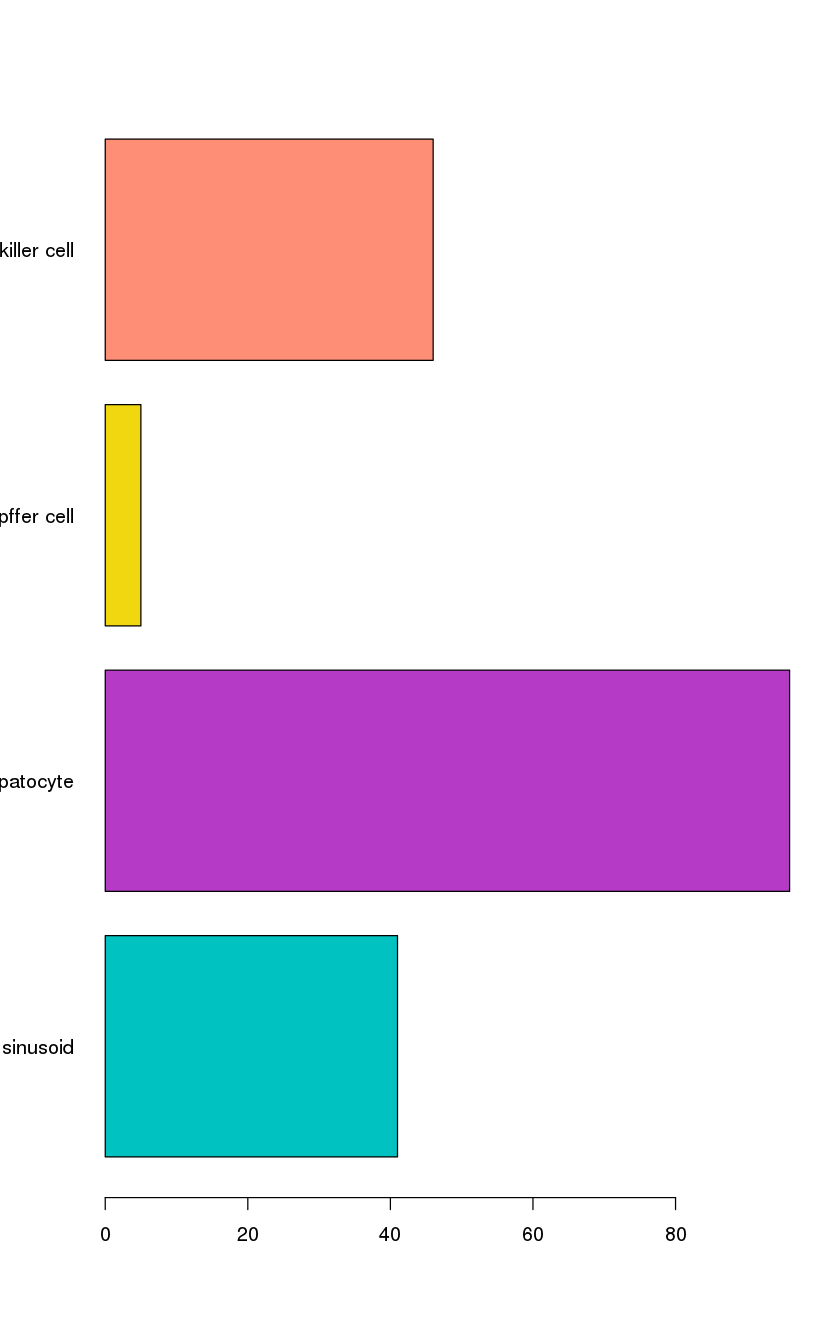

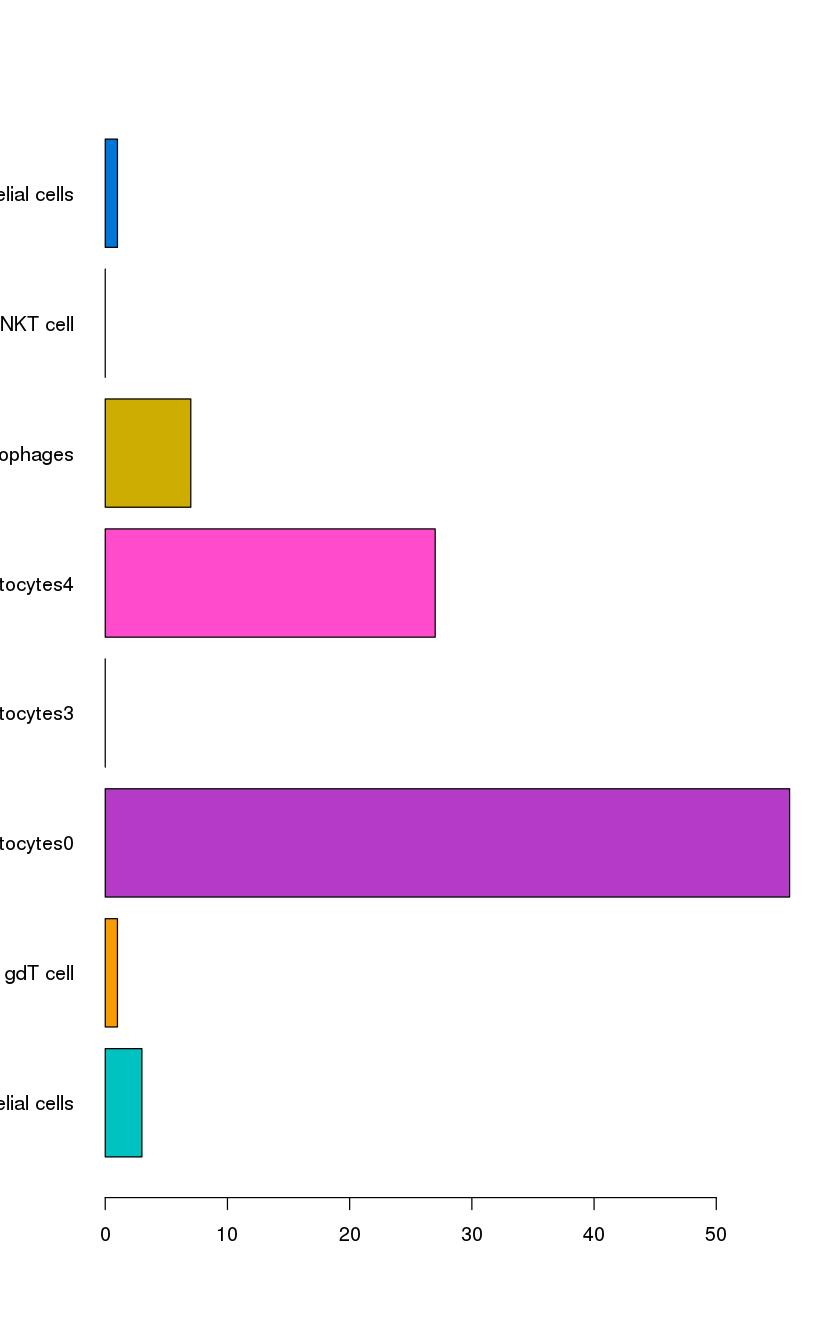

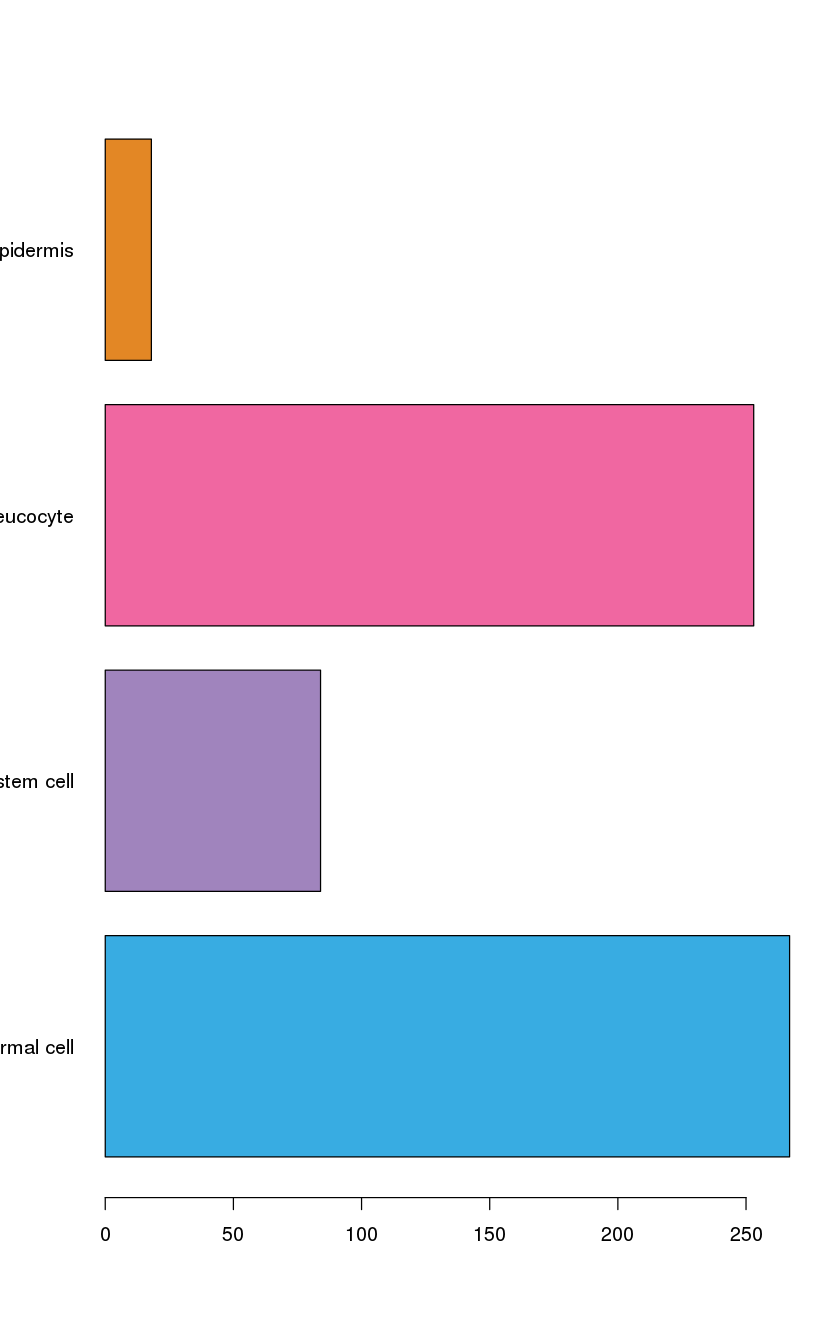

In [70]:
check_interaction = function(tissue, cells)
{
    qtls = read.table(paste("qtls/", tissue, "/analysis/egenes."     , tissue, ".txt", sep = ""), header = TRUE)
    lmms = read.table(paste("qtls/", tissue, "/analysis/lmm_compare.", tissue, ".txt", sep = ""), header = TRUE, check.names = FALSE)
    
    tofdr = colnames(lmms)
    tofdr = tofdr[grepl("pval$", tofdr) == TRUE & tofdr != "min_pval"]

    for (x in tofdr)
    {
        lmms[,gsub("pval", "qval", x)] = qvalue(lmms[,x])$qvalues
    }
    
    write.table(lmms, paste("qtls/", tissue, "/analysis/lmm_compare_fdr.", tissue, ".txt", sep = ""), quote = FALSE, sep = "\t", row.names = FALSE, col.names = TRUE)
    
    out   = cells
    out$n = 0
    for (ii in 1:nrow(out))
    {
        x = out[ii, "name"]
        out[ii, "n"] = nrow(lmms[lmms[,paste("gt", x, "qval", sep = ":")] < 0.1, ])
    }
    
    barplot(out$n, names.arg = gsub("_", " ", out$celltypes), horiz = TRUE, col = out$color, las = 1)
    
    return(out)

}

tobar = lapply(c("liver_cells", "liver2_cells", "skin_cells"), function(x){check_interaction(x, cell2col[[x]])})
names(tobar) = c("liver_cells", "liver2_cells", "skin_cells")


In [71]:
str(egenes)

'data.frame':	5 obs. of  6 variables:
 $ tissue: chr  "liver2_cells" "liver_cells" "liver_original" "skin_cells" ...
 $ genes : int  19621 19621 19621 24029 24029
 $ egenes: int  10177 7840 1369 14174 9232
 $ name  : chr  "Liver (human cell populations)" "Liver (mouse cell populations)" "Liver (bulk resolution)" "Skin (mouse cell populations)" ...
 $ color : chr  "#800000" "#CD3700" "#FF7256" "#000080" ...
 $ y     : num  4 3 5 1 2


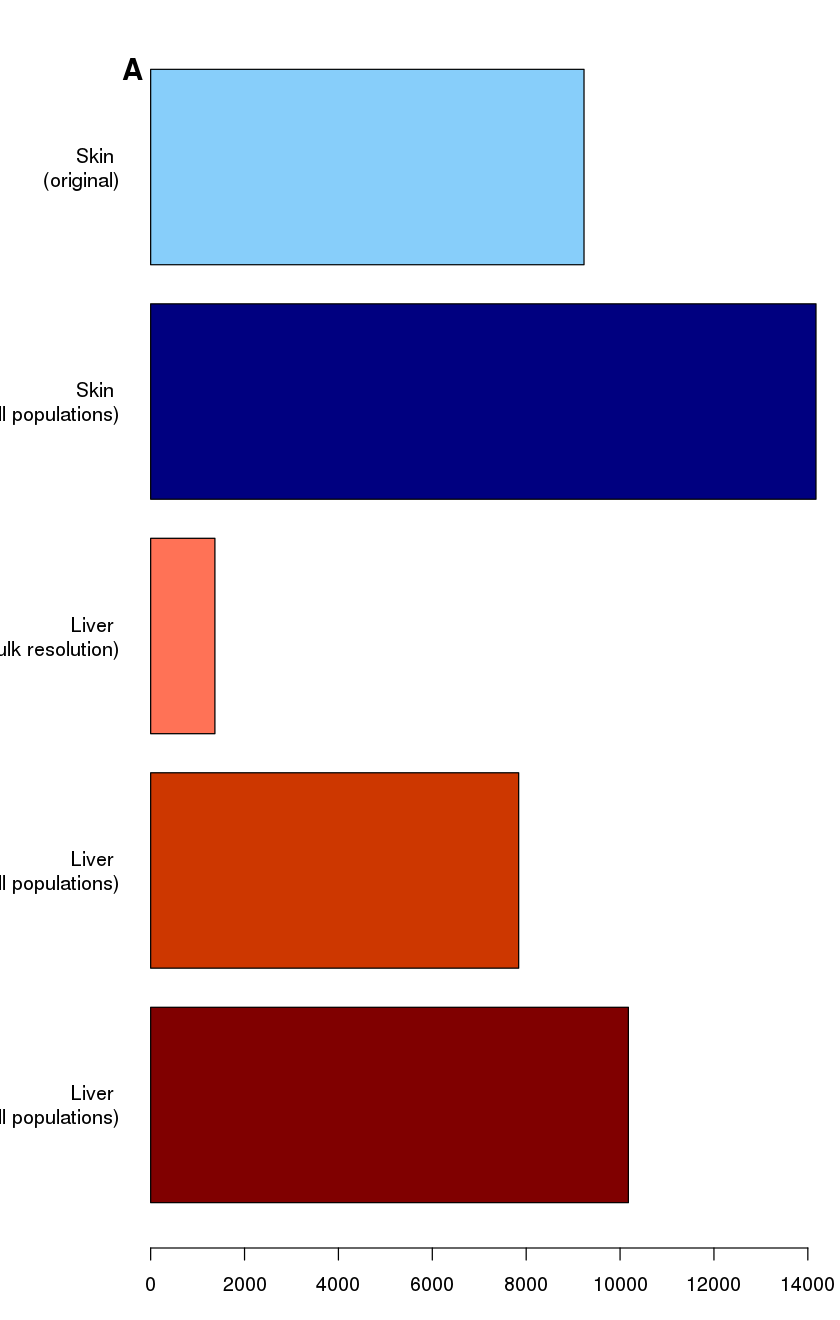

In [72]:



barplot_egenes = function(panel)
{
    barplot(egenes$egenes, names.arg = gsub("\\(", "\n(", egenes$name), horiz = TRUE, las = 1, col = egenes$color)
    mtext(text = panel, side = 2, line = 0, cex = 1.5 , at = 6, las = 1, font = 2)
    
}


par(mar = c(3,6,1,1))
barplot_egenes("A")


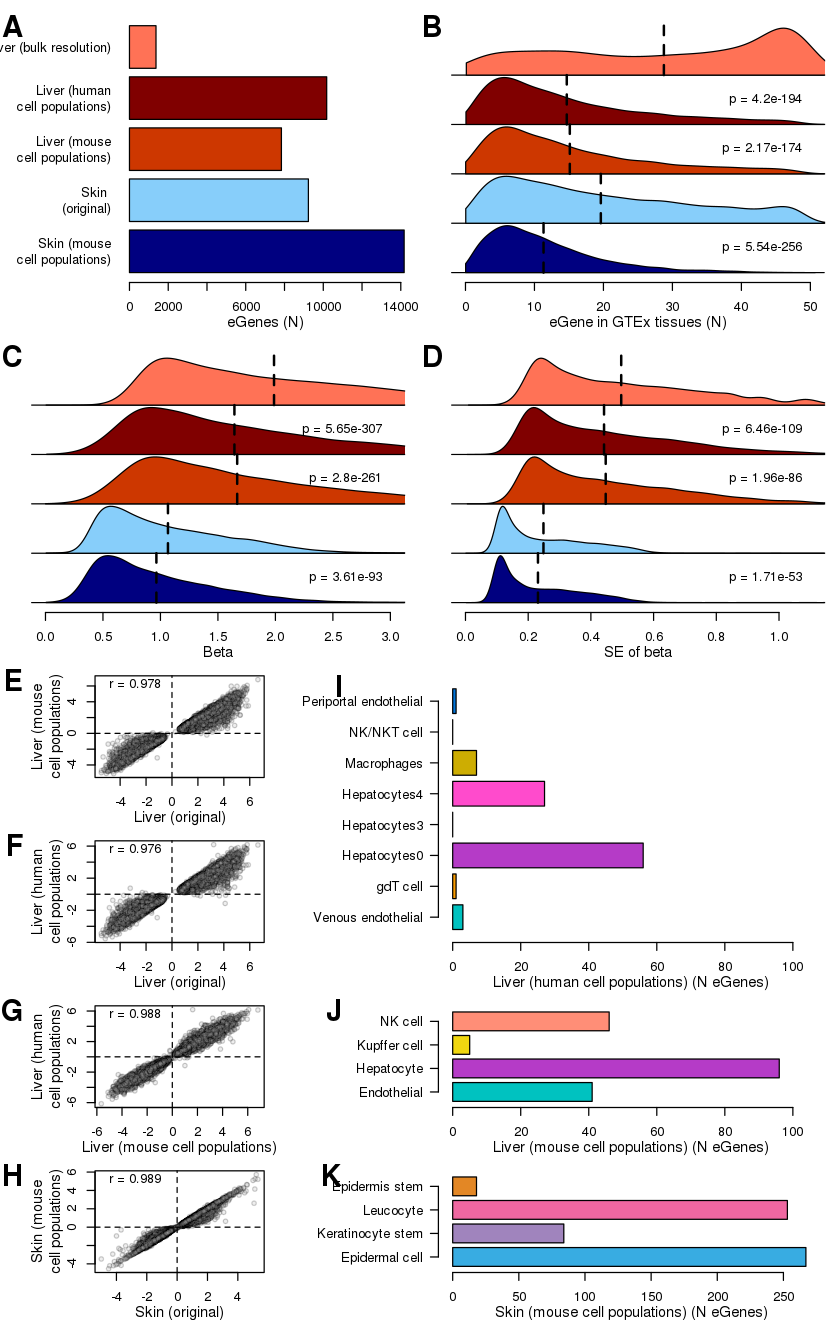

In [73]:
compare_qtls = function(tissue1, tissue2, tissue, name1, name2, panel)
{
    qtls1          = read.table(paste("qtls/", tissue1, "/analysis/egenes.", tissue1, ".txt", sep = ""), header = TRUE)
    qtls2          = read.table(paste("qtls/", tissue2, "/analysis/egenes.", tissue2, ".txt", sep = ""), header = TRUE)
    qtls1$gene_var = paste(qtls1$gene_id, qtls1$id)
    qtls2$gene_var = paste(qtls2$gene_id, qtls2$id)
    qtls           = merge(qtls1[,c("gene_var", "egene", "beta", "se", "bonferroni")], qtls2[,c("gene_var", "egene", "beta", "se", "bonferroni")], by = "gene_var", suffixes = 1:2)
    
    plot(qtls$beta1, qtls$beta2, bg = "#aaaaaa33", col = "#00000033", pch = 21, cex = 0.75, xlab = "", ylab = "", main = "")
    
    abline(h = 0, lty = "dashed")
    abline(v = 0, lty = "dashed")
    mtext(text = name1, side = 1, line = 2  , cex = 0.75)
    mtext(text = name2, side = 2, line = 2  , cex = 0.75)
    mtext(text = panel, side = 2, line = 4.5, cex = 1.5 , at = max(qtls$beta2), las = 1, font = 2)
    
    text(x = min(qtls$beta1), y = max(qtls$beta2) * 0.9, labels = paste("r", signif(cor(qtls$beta1, qtls$beta2), digits = 3), sep = " = "), pos = 4)
}

check_interaction_divide = function(tissue, cells, name, panel)
{
    if (grepl("Liver", name) == TRUE){qtls2 = read.table(paste("qtls/", "liver_original", "/analysis/egenes.", "liver_original", ".txt", sep = ""), header = TRUE)}
    if (grepl("Skin" , name) == TRUE){qtls2 = read.table(paste("qtls/", "skin_original" , "/analysis/egenes.", "skin_original" , ".txt", sep = ""), header = TRUE)}
    #qtls = read.table(paste("qtls/", tissue, "/analysis/egenes."     , tissue, ".txt", sep = ""), header = TRUE)
    lmms = read.table(paste("qtls/", tissue, "/analysis/lmm_compare.", tissue, ".txt", sep = ""), header = TRUE)
    
    lmms$original = FALSE
    lmms[lmms$gene_id %in% qtls2[qtls2$egene == TRUE, "gene_id"], "original"] = TRUE
    
    out           = as.data.frame.matrix(table(lmms[, c("best", "original")]), stringsAsFactors = FALSE)
    out$name      = rownames(out)
    out           = out[out$name != "gt",] 
    colnames(out) = c("unique", "shared", "name")
    out$name      = gsub("gt:", "", out$name)
    out           = merge(cells, out)
    out$celltypes = gsub("_", " ", out[, "celltypes"])
    #return(out)
    
    plot(1,1, type = "n", ylim = c(0.5, nrow(out) + 0.5), xlim = c(0, max(rowSums(out[,c("shared", "unique")]))), xlab = "", ylab = "", axes = FALSE)
    axis(1)
    axis(2, at = 1:nrow(out), labels = out$celltypes, las = 1)
    
    rect(xleft = 0         , xright = out$shared             , ybottom = 1:nrow(out) - 0.4, ytop = 1:nrow(out) + 0.4, col =       out[, "color"]                 )
    rect(xleft = out$shared, xright = out$shared + out$unique, ybottom = 1:nrow(out) - 0.4, ytop = 1:nrow(out) + 0.4, col = paste(out[, "color"], "44", sep = ""))

    mtext(text = paste(name, "(N eGenes)"), side = 1, line = 2  , cex = 0.75)
    mtext(text = panel                    , side = 2, line = 6  , cex = 1.5, at = nrow(out) + 0.5, las = 1, font = 2)
    
    out$tissue = name
    out$celltypes = gsub("\\n", " ", out$celltypes)
    
    return(out[,c("tissue", "celltypes", "unique", "shared")])
}

check_interaction = function(tissue, cells, name, panel)
{
    if (grepl("Liver", name) == TRUE){qtls2 = read.table(paste("qtls/", "liver_original", "/analysis/egenes.", "liver_original", ".txt", sep = ""), header = TRUE)}
    if (grepl("Skin" , name) == TRUE){qtls2 = read.table(paste("qtls/", "skin_original" , "/analysis/egenes.", "skin_original" , ".txt", sep = ""), header = TRUE)}
    if (grepl("Liver", name) == TRUE){xlims = c(0, 105)}
    if (grepl("Skin" , name) == TRUE){xlims = c(0, 270)}
    lmms = read.table(paste("qtls/", tissue, "/analysis/lmm_compare.", tissue, ".txt", sep = ""), header = TRUE, check.names = FALSE)
    
    lmms$original = FALSE
    lmms[lmms$gene_id %in% qtls2[qtls2$egene == TRUE, "gene_id"], "original"] = TRUE
    
    tofdr = colnames(lmms)
    tofdr = tofdr[grepl("pval$", tofdr) == TRUE & tofdr != "min_pval"]

    for (x in tofdr)
    {
        lmms[,gsub("pval", "qval", x)] = qvalue(lmms[,x])$qvalues
    }
    
    write.table(lmms, paste("qtls/", tissue, "/analysis/lmm_compare_fdr.", tissue, ".txt", sep = ""), quote = FALSE, sep = "\t", row.names = FALSE, col.names = TRUE)
    
    out   = cells
    out$n = 0
    for (ii in 1:nrow(out))
    {
        x = out[ii, "name"]
        out[ii, "n"] = nrow(lmms[lmms[,paste("gt", x, "qval", sep = ":")] < 0.1, ])
    }
    
    #barplot(out$n, names.arg = gsub("_", " ", out$celltypes), horiz = TRUE, col = out$color, las = 1)
    
    plot(1,1, type = "n", ylim = c(0.5, nrow(out) + 0.5), xlim = xlims, xlab = "", ylab = "", axes = FALSE)
    axis(1)
    axis(2, at = 1:nrow(out), labels = gsub("_", " ", out$celltypes), las = 1)
    
    rect(xleft = 0, xright = out$n, ybottom = 1:nrow(out) - 0.4, ytop = 1:nrow(out) + 0.4, col = out[, "color"])

    mtext(text = paste(name, "(N eGenes)"), side = 1, line = 2  , cex = 0.75)
    mtext(text = panel                    , side = 2, line = 6  , cex = 1.5, at = nrow(out) + 0.5, las = 1, font = 2)
    return(out)

}

check_interaction_old = function(tissue, cells, name, panel)
{
    if (grepl("Liver", name) == TRUE){qtls2 = read.table(paste("qtls/", "liver_original", "/analysis/egenes.", "liver_original", ".txt", sep = ""), header = TRUE)}
    if (grepl("Skin" , name) == TRUE){qtls2 = read.table(paste("qtls/", "skin_original" , "/analysis/egenes.", "skin_original" , ".txt", sep = ""), header = TRUE)}
    
    #qtls = read.table(paste("qtls/", tissue, "/analysis/egenes."     , tissue, ".txt", sep = ""), header = TRUE)
    lmms = read.table(paste("qtls/", tissue, "/analysis/lmm_compare.", tissue, ".txt", sep = ""), header = TRUE)
    
    lmms$original = FALSE
    lmms[lmms$gene_id %in% qtls2[qtls2$egene == TRUE, "gene_id"], "original"] = TRUE
    
    out           = as.data.frame.matrix(table(lmms[, c("best", "original")]), stringsAsFactors = FALSE)
    out$name      = rownames(out)
    out           = out[out$name != "gt",] 
    colnames(out) = c("unique", "shared", "name")
    out$name      = gsub("gt:", "", out$name)
    out           = merge(cells, out)
    out$celltypes = gsub("_", " ", out[, "celltypes"])
    #return(out)
    
    plot(1,1, type = "n", ylim = c(0.5, nrow(out) + 0.5), xlim = c(0,350), xlab = "", ylab = "", axes = FALSE)
    axis(1)
    axis(2, at = 1:nrow(out), labels = out$celltypes, las = 1)
    
    rect(xleft = 0, xright = out$shared + out$unique, ybottom = 1:nrow(out) - 0.4, ytop = 1:nrow(out) + 0.4, col = out[, "color"])

    mtext(text = paste(name, "(N eGenes)"), side = 1, line = 2  , cex = 0.75)
    mtext(text = panel                    , side = 2, line = 6  , cex = 1.5, at = nrow(out) + 0.5, las = 1, font = 2)
    
    out$tissue = name
    out$celltypes = gsub("\\n", " ", out$celltypes)
    
    return(out[,c("tissue", "celltypes", "unique", "shared")])
}

plot_densities_gtex = function(qtls2n, column, filter, xmax, main, panel)
{
    if (filter == TRUE ){qtl2tissues_true  = lapply(qtls2n, function(x){x[x$egene == TRUE & x$overlap == TRUE , column]})}
    if (filter == TRUE ){qtl2tissues_false = lapply(qtls2n, function(x){x[x$egene == TRUE & x$overlap == FALSE, column]})}
    if (filter == FALSE){qtl2tissues_true  = lapply(qtls2n, function(x){x[, column]})}
    if (filter == FALSE){qtl2tissues_false = lapply(qtls2n, function(x){x[, column]})}
    names(qtl2tissues_true ) = names(qtl2tissues_true )
    names(qtl2tissues_false) = names(qtl2tissues_false)

    dens_list_true  = lapply(qtl2tissues_true , density_lines)
    dens_list_false = lapply(qtl2tissues_false, density_lines)

    tissue2name = tissue2name[order(tissue2name$y, decreasing = TRUE),]
    
    plot(1,1, type = "n", xlim = c(0, xmax), ylim = c(1,6), xlab = "", ylab = "", axes = FALSE)
    axis(1)
    mtext(text = main, side = 1, line = 2, cex = 0.75)
    abline(h = 1:5)

    polygon_density(dens_list_true [["liver_original"]], tissue2name[tissue2name$tissue == "liver_original", "color"], 6 - 1)
    polygon_density(dens_list_false[["liver2_cells"  ]], tissue2name[tissue2name$tissue == "liver2_cells"  , "color"], 6 - 2)
    polygon_density(dens_list_false[["liver_cells"   ]], tissue2name[tissue2name$tissue == "liver_cells"   , "color"], 6 - 3)
    polygon_density(dens_list_true [["skin_original" ]], tissue2name[tissue2name$tissue == "skin_original" , "color"], 6 - 4)
    polygon_density(dens_list_false[["skin_cells"    ]], tissue2name[tissue2name$tissue == "skin_cells"    , "color"], 6 - 5)
    
    segments(x0 = c(mean(qtl2tissues_true [["liver_original"]]), 
                    mean(qtl2tissues_false[["liver2_cells"  ]]), 
                    mean(qtl2tissues_false[["liver_cells"   ]]), 
                    mean(qtl2tissues_true [["skin_original" ]]), 
                    mean(qtl2tissues_false[["skin_cells"    ]])), 
             y0 = 6 - (1:5), y1 = 7 - (1:5), col = "#000000", lty = "dashed", lwd = 2)

    #text(x = rep(xmax/2, 5), y = (5:1)+0.5, labels = tissue2name$name, pos = 3)
    mtext(text = panel, side = 2, line = 0.5, cex = 1.5 , at = 6, las = 1, font = 2)

    text(xmax, 4.5, labels = paste("p", signif(wilcox.test(qtl2tissues_false[["liver2_cells"]], qtl2tissues_true[["liver_original"]])$p.value, digits = 3), sep = " = "), pos = 2)
    text(xmax, 3.5, labels = paste("p", signif(wilcox.test(qtl2tissues_false[["liver_cells" ]], qtl2tissues_true[["liver_original"]])$p.value, digits = 3), sep = " = "), pos = 2)
    text(xmax, 1.5, labels = paste("p", signif(wilcox.test(qtl2tissues_false[["skin_cells"  ]], qtl2tissues_true[["skin_original" ]])$p.value, digits = 3), sep = " = "), pos = 2)
    
    return(data.frame(main     = main,
                      tissue   = c("liver2_cells", "liver_cells", "skin_cells"), 
                      cells    = c(mean(qtl2tissues_false[["liver2_cells"  ]], na.rm = TRUE), mean(qtl2tissues_false[["liver_cells"   ]], na.rm = TRUE), mean(qtl2tissues_false[["skin_cells"   ]], na.rm = TRUE)),
                      original = c(mean(qtl2tissues_true [["liver_original"]], na.rm = TRUE), mean(qtl2tissues_true [["liver_original"]], na.rm = TRUE), mean(qtl2tissues_true [["skin_original"]], na.rm = TRUE))
                     ))
}


barplot_egenes = function(panel)
{
    egenes = egenes[order(egenes$y, decreasing = FALSE),]
    barplot(egenes$egenes, names.arg = gsub("\\(ori", "\n(ori", gsub(" cell", "\ncell", egenes$name)), horiz = TRUE, las = 1, col = egenes$color)
    mtext(text = panel, side = 2, line = 6.5, cex = 1.5 , at = 6, las = 1, font = 2)
    mtext(text = "eGenes (N)", side = 1, line = 2, cex = 0.75)
}




liver2_cells = data.frame(celltypes = c('Central_venous\nsinusoidal\nendothelial_cells', 'gdT_cell', 'Hepatocytes0', 'Hepatocytes3', 'Hepatocytes4', 'Inflammatory\nmacrophages', 'NK/NKT_cell', 'Periportal_sinusoidal\nendothelial_cells'),
                          name      = c("endothelial_venous"                           , "gdt"     , "hepatocyte0" , "hepatocyte3" , "hepatocyte4" , "macrophage"               , "nkt_cell", "endothelial_periportal"                 ),
                          color     = c("#00c2c0"                                      , "#fa9c00" , "#b53bc7"     ,  "#f1a8f2"    , "#ff4bcc"     , "#cdad02"                  , "#ff8e77" , "#0075da"                                ))

liver_cells = data.frame(celltypes = c('Endothelial_cell\nof_hepatic_sinusoid', 'Hepatocyte', 'Kupffer_cell', 'NK_cell'),
                         name      = c("endothelial"                          , "hepatocyte", "kupffer_cell", "nk_cell"),
                         color     = c("#00c2c0"                              , "#b53bc7"   , "#f0d710"     , "#ff8e77"))

skin_cells = data.frame(celltypes = c("Epidermal_cell", "Keratinocyte\nstem_cell", "Leucocyte", "Stem_cell\nof_epidermis"),
                        name      = c("epidermal"     , "keratinocyte_stem_cell" , "leucocyte", "epidermal_stem_cell"    ),
                        color     = c("#38ace2"       , "#a084bd"                , "#f067a1"  , "#e38725"                ))

liver2_cells = data.frame(celltypes = c('Venous_endothelial', 'gdT_cell', 'Hepatocytes0', 'Hepatocytes3', 'Hepatocytes4', 'Macrophages', 'NK/NKT_cell', 'Periportal_endothelial'),
                          name      = c("endothelial_venous", "gdt"     , "hepatocyte0" , "hepatocyte3" , "hepatocyte4" , "macrophage" , "nkt_cell"   , "endothelial_periportal"),
                          color     = c("#00c2c0"           , "#fa9c00" , "#b53bc7"     ,  "#f1a8f2"    , "#ff4bcc"     , "#cdad02"    , "#ff8e77"    , "#0075da"               ))

liver_cells = data.frame(celltypes = c('Endothelial', 'Hepatocyte', 'Kupffer_cell', 'NK_cell'),
                         name      = c("endothelial", "hepatocyte", "kupffer_cell", "nk_cell"),
                         color     = c("#00c2c0"    , "#b53bc7"   , "#f0d710"     , "#ff8e77"))

skin_cells = data.frame(celltypes = c("Epidermal_cell", "Keratinocyte_stem"      , "Leucocyte", "Epidermis_stem"     ),
                        name      = c("epidermal"     , "keratinocyte_stem_cell" , "leucocyte", "epidermal_stem_cell"),
                        color     = c("#38ace2"       , "#a084bd"                , "#f067a1"  , "#e38725"            ))

cell2col = list(liver_cells = liver_cells, liver2_cells = liver2_cells, skin_cells = skin_cells, font = 2)


options(repr.plot.width=7, repr.plot.height=11)

layout(cbind(c(8,8,10,10,1:4), c(8,8, 10,10,1:4), c(8,8,10,10,5,5,6,7), c(9,9,11,11,5,5,6,7), c(9,9,11,11,5,5,6,7), c(9,9,11,11,5,5,6,7)))

par(mar = c(3,6,1,1))

compare_qtls("liver_original", "liver_cells" , "liver", "Liver (original)"              , "Liver (mouse\ncell populations)", "E")
compare_qtls("liver_original", "liver2_cells", "liver", "Liver (original)"              , "Liver (human\ncell populations)", "F")
compare_qtls("liver_cells"   , "liver2_cells", "liver", "Liver (mouse cell populations)", "Liver (human\ncell populations)", "G")
compare_qtls("skin_original" , "skin_cells"  , "skin" , "Skin (original)"               , "Skin (mouse\ncell populations)" , "H")

par(mar = c(3,10,1,1))

out2 = check_interaction("liver2_cells", cell2col[["liver2_cells"]], "Liver (human cell populations)", "I")
out1 = check_interaction("liver_cells" , cell2col[["liver_cells" ]], "Liver (mouse cell populations)", "J")
out3 = check_interaction("skin_cells"  , cell2col[["skin_cells"  ]], "Skin (mouse cell populations)" , "K")

cell2cell = rbind(out1, out2, out3)

par(mar = c(3,8,1,1))
barplot_egenes("A")

par(mar = c(3,2,1,1))
outb1 = plot_densities_gtex(qtls2n, "n"       , filter = TRUE , 50  , main = "eGene in GTEx tissues (N)", "B")
outb2 = plot_densities_gtex(qtls2n, "abs_beta", filter = FALSE,  3  , main = "Beta"                     , "C")
outb3 = plot_densities_gtex(qtls2n, "se"      , filter = FALSE,  1.1, main = "SE of beta"               , "D")

distr = rbind(outb1, outb2, outb3)


In [74]:
distr

main,tissue,cells,original
eGene in GTEx tissues (N),liver2_cells,14.6851830,28.7638376
eGene in GTEx tissues (N),liver_cells,15.1249210,28.7638376
eGene in GTEx tissues (N),skin_cells,11.3164321,19.6215170
Beta,liver2_cells,1.6434867,1.9880476
Beta,liver_cells,1.6676417,1.9880476
Beta,skin_cells,0.9647676,1.0653698
SE of beta,liver2_cells,0.4419342,0.4967158
SE of beta,liver_cells,0.4472642,0.4967158
SE of beta,skin_cells,0.2311835,0.2487347


In [75]:
out       = rbind(out1, out2, out3)
out$tot   = rowSums(out[,c("unique", "shared")])
out$ratio = out$unique / out$tot

out_dt = data.table(out)

totest = data.frame(out_dt[ , .(sum = sum(tot), mean = mean(tot), mean_ratio = mean(ratio), unique = sum(unique), shared = sum(shared), .N), by = .(tissue)] )
totest = merge(totest, egenes[,c("genes", "egenes", "name")], by.x = "tissue", by.y = "name")
totest$not = totest$egenes - totest$sum
totest$original = c(1369, 1369, 9232)

totest$not_unique   = totest$egenes   - totest$unique
totest$not_original = totest$original - totest$shared

fisher.test(as.matrix(totest[totest$tissue %in% c("Liver (human cell populations)", "Liver (mouse cell populations)"), c("sum", "not")]))
fisher.test(as.matrix(totest[totest$tissue %in% c("Liver (human cell populations)", "Liver (mouse cell populations)"), c("sum", "not")]))$p.value

fisher.test(matrix(as.numeric(totest[totest$tissue == "Liver (human cell populations)", c("unique", "not_unique", "shared", "not_original")]), nrow = 2))
fisher.test(matrix(as.numeric(totest[totest$tissue == "Liver (mouse cell populations)", c("unique", "not_unique", "shared", "not_original")]), nrow = 2))
fisher.test(matrix(as.numeric(totest[totest$tissue == "Skin (mouse cell populations)" , c("unique", "not_unique", "shared", "not_original")]), nrow = 2))


sum(totest$sum)

totest$unique/totest$egenes
totest$shared/totest$original


totest

ERROR: Error in `[.data.frame`(out, , c("unique", "shared")): undefined columns selected


In [ ]:
as.numeric(totest[totest$tissue == "Liver (human cell populations)", c("unique", "not_unique", "shared", "not_original")])

# OLD

In [ ]:
toqq = function(x)
{
    x$logp = -log10(x$bonferroni)
    x = x[order(x$logp),]
    x$exp = -log10((nrow(x):1) / nrow(x))
    
    return(x)
}

tissues         = c("liver_original", "liver_cells", "liver2_cells", "skin_original", "skin_cells"  )
qtl_list        = lapply(tissues , function(x){read.table(paste("qtls/", x, "/analysis/egenes.", x, ".txt", sep = ""), header = TRUE)})
qtl_list        = lapply(qtl_list, toqq)
names(qtl_list) = tissues
tissue2name     = data.frame(tissue = tissues, name = c("Liver (original)", "Liver (mouse cell populations)", "Liver (human cell populations)", "Skin (original)", "Skin (mouse cell populations)" ), color = c("#FF7256", "#CD3700", "#800000", "#87CEFA", "#000080"))

In [ ]:
run_qqplot = function(tissues, qtl_list, tissue2name)
{
    plot(1,1, type = "n", xlab = "", ylab = "", xlim = range(as.numeric(unlist(lapply(qtl_list, function(x){range(x$exp)})))), ylim = range(as.numeric(unlist(lapply(qtl_list, function(x){range(x$logp)})))))
    
    invisible(lapply(tissues, function(tissue){points(qtl_list[[tissue]][,"exp"], qtl_list[[tissue]][,"logp"], col = tissue2name[tissue2name$tissue == tissue, "color"], pch = 16)}))
}

run_qqplot(tissues, qtl_list, tissue2name)
